In [1]:
import numpy as np
from os import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Selection of the active channels for the common mode noise determination
# Change the variables excludeDetectors and excludeChannels to provide the
# channels to be removed from the calculation, if all channels are to be
# used set the two variables to [].
# Numbering is from detector #0 (ch. #0 to ch. #7) to detector #3 (ch. #24
# to ch. #31)

global chMask

Mask = np.ones((32,1),dtype='int')
#excludeDetectors = [1,3]
excludeChannels = []
excludeDetectors = [] #1,2,3
excludeChannels = []

for exclude in excludeDetectors:
    for i in range(8):
        Mask[exclude*8+i] = 0
for exclude in excludeChannels:
    Mask[exclude] = 0

chMask = (Mask > 0).nonzero()[0]
print('Common Mode Noise active channels are: {}'.format(chMask))

Common Mode Noise active channels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [3]:
# Function used to determine the pedestals. It uses only the events where
# all signals are below thr. The algorithm calculates the pedestals channel
# by channel by removing iteratively the channels that fall outside the
# range -nsigma*sigma_i < mean_i < nsigma*sigma_i. nsigma has a default
# value of 3.0.
# The function returns the pedestals (mean) and the standard deviation of
# the values selected to determine the pedestals (std)

def Pedestals(ev, thr, nsigma=3.):
    sel = np.ones(ev.shape,dtype='int')
    for i in range(32):
        sel[:,i] *= (ev[:,i] <= thr[i])
    std = np.zeros_like(ev[0,:])
    mean = np.zeros_like(std)
    for i in range(32):
        idx = (sel[:,i] > 0).nonzero()[0]
        v = ev[idx,i]
        mean[i] = v.mean()
        stdprev = v.std()
        idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
        mean[i] = v[idx].mean()
        std[i] = v[idx].std()
        while (std[i] < stdprev):
            stdprev = std[i]
            idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
            mean[i] = v[idx].mean()
            std[i] = v[idx].std()
    return [mean, std]

In [4]:
# Function used to determine the common mode noise. It subtracts the pedestals
# from the ADC values and uses the same algorithm of the Pedestal function,
# this time event by event, to select the channels without signal.
# The function returns the common mode channel selection matrix (ch), the number
# of common mode channels on each event (chn), the raw common mode noise (mean),
# and the event standard devation of the common mode channels (std) that can be
# used to select events where the common mode can be calculated correctly (those
# with low std).

def CMNchannels(ev, peds, nsigma=3.):
    global chMask
    v = ev-peds
    v = v[:,chMask]
    ch = np.zeros_like(v)
    stdprev = v.std(axis=1).reshape(v.shape[0],1)
    std = np.zeros_like(stdprev)
    mean = v.mean(axis=1)
    chn = np.zeros_like(std)
    for i in range(v.shape[0]):
        vv = v[i,:]
        chmax = (vv == vv.max()).nonzero()[0]
        chidx = np.array(range(v.shape[1]))
        chidx = np.delete(chidx,chmax)
        stdprev[i] = vv[chidx].std()
        mean[i] = vv[chidx].mean()
        chidx = (np.abs(vv-mean[i]) < nsigma*stdprev[i])
        idx = chidx.nonzero()[0]
        mean[i] = vv[idx].mean()
        std[i] = vv[idx].std()
        while (std[i] < stdprev[i]):
            stdprev[i] = std[i]
            chidx = (vv-mean[i] < nsigma*stdprev[i])
            idx = chidx.nonzero()[0]
            mean[i] = vv[idx].mean()
            std[i] = vv[idx].std()
        ch[i,:] = chidx[:]
        chn[i] = len(idx)
    return [ch, chn, mean, std]

In [5]:
# Function used by the minimization to determine the common mode noise coupling
# to thee various channels (common mode noise "gain"). It uses global variables
# containing the pedestal subtracted event data and the common mode noise selection
# matrix.

def cmnGain(p):
    global cmnEv
    global cmnCh
    n = cmnEv.shape[0]
    g = np.array(p)
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = ((cmnEv*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    y = (((cmnEv-cmn_matrix)*cmnCh)**2).sum()
    return y

In [6]:
# Function used to remove the common mode noise from the event data. It uses
# the raw event data, the pedestals, the common mode channels selection matrix
# and the common mode noise coupling gains. The function returns the pedestal
# and common mode corrected event data (v) and the event common mode noise (cmn).
# Note: the common mode noise is removed only for the active channels

def removeDisturbances(ev, peds, ch, g):
    global chMask
    v = ev-peds
    vv = v[:,chMask]
    n = vv.shape[0]
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*ch).sum(axis=1)).reshape(n,1)
    cmn = ((vv*ch).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    vv = vv-cmn_matrix
    for i,j in enumerate(chMask):
        v[:,j] = vv[:,i]
    return [v, cmn]

In [7]:
# Function used to determine the pedestals (ch_mean) and the noise (ch_std)
# after the pedestals and the common mode noise has been subtracted from the
# event data. The new pedestals should all be "zero" (within the noise limits)
# and the new noise standard deviations should be equal or smaller than the
# one calculated at the beginning by the pedestals determination function.

def histParameters(energy, thr, nsigma = 3.):
    ch_std = np.zeros(32)
    ch_mean = np.zeros(32)
    for i in range(32):
        idx = (energy[:,i] < thr).nonzero()[0]
        data = energy[idx,i]
        old_std = data.std()
        ch_mean[i] = data.mean()
        idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
        ch_std[i] = data[idx].std()
        ch_mean[i] = data[idx].mean()
        while (ch_std[i] < old_std):
            old_std = ch_std[i]
            idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
            ch_std[i] = data[idx].std()
            ch_mean[i] = data[idx].mean()
    return [ch_mean, ch_std]

In [8]:
# Load the file. Notice that this is very slow, be patient!

try:
    #fname = 'Run_11_08_2022_11.29.16_1hr_self_130_ZS.txt' # muoni self con/senza ZS
    #fname = 'self_americio_ch8_1hr.txt' # americio
    #fname = 'test_NO_americio_self_1hr_TH_214_8ch_tp4.txt' # no americio
    fname = 'xray_205_400_FTh_2mins.txt' # THR 205 2 mins
    fname = 'xray_206_400_FTh_2mins.txt' # THR 206 2 mins
    fname = 'IT_400_xray_207_FTh_10mins_tau5.txt' # THR 207 10 mins
    ev, evtype, module, chtype, channel, adc = np.loadtxt(fname, dtype='int', comments='#', usecols=(0, 1, 2, 3, 4, 5), unpack=True)
    N = np.unique(ev)
except:
    pass

In [9]:
# Print the number of events in the file
print('Events in file: ', len(N))
Event = []

idx = (module == 0).nonzero()[0]  # REMEMBER TO UPDATE THE MODULE NUMBER !!!!!!!!!!!!!!
evn = ev[idx]
ch = channel[idx]
val = adc[idx]

evnw = evn.view()
chw = ch.view()
valw = val.view()

# Determine the good events and store them in the Event list along with the event
# number and the channel numbers. This step eliminates all 0 and all 2047 events
# and the events where there is S&H saturation (changing the neg_saturation and
# the pos_saturation values can be used to play with saturation)

selected = 0
all_neg_saturation = 0
all_pos_saturation = 0
some_neg_saturation = 0
some_pos_saturation = 0
neg_saturation = 40.
pos_saturation = 2020.
if (len(N)):
    for n in N:
        # check only 40 rows at a time
        if (len(evnw) > 40):
            idx = (evnw[0:40] == n).nonzero()[0]
        else:
            idx = (evnw == n).nonzero()[0]
        # verify that the event contains 32 rows and all channels are present
        if ((len(idx) == 32) and (ch[idx].sum() == 496)):
            # verify saturation
            if ((valw[idx] <= neg_saturation).all()):
                all_neg_saturation += 1
            elif ((valw[idx] <= neg_saturation).any()):
                some_neg_saturation += 1
            elif ((valw[idx] >= pos_saturation).all()):
                all_pos_saturation += 1
            elif ((valw[idx] >= pos_saturation).any()):
                some_pos_saturation += 1
            else:
                Nch = chw[idx]
                ADCs = valw[idx]
                Event.append([n, Nch, ADCs])
                selected += 1
        ii = len(idx)
        evnw = evnw[ii:].view()
        chw = chw[ii:].view()
        valw = valw[ii:].view()

# Plot the good/bad events statistics
print('Real events: ', selected+all_neg_saturation+some_neg_saturation+all_pos_saturation+some_pos_saturation)
print('All negative saturated: ', all_neg_saturation)
print('Some negative saturated: ', some_neg_saturation)
print('All positive saturated: ', all_pos_saturation)
print('some positive saturated: ', some_pos_saturation)
print('Selected: ', selected)

Events in file:  442600
Real events:  442600
All negative saturated:  0
Some negative saturated:  6
All positive saturated:  67
some positive saturated:  0
Selected:  442527


In [10]:
# Prepare the event and pedestal variables for the analysis

global events
global peds
n = len(Event)
peds = np.zeros((1, 32))
events = np.empty((n, 32))
for i, data in enumerate(Event):
    events[i,:] = data[2]

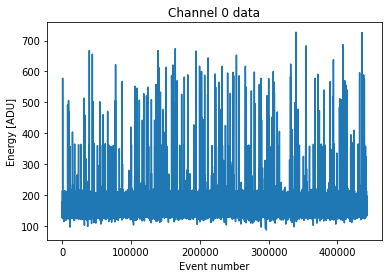

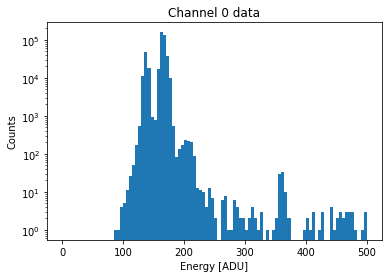

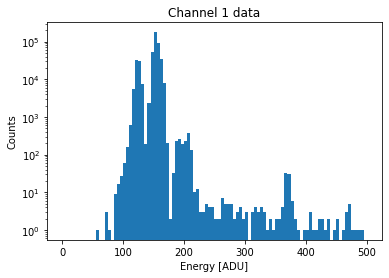

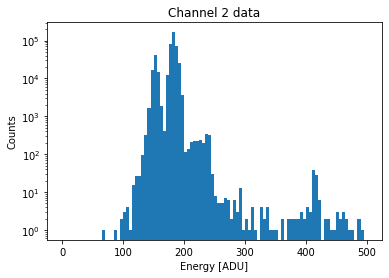

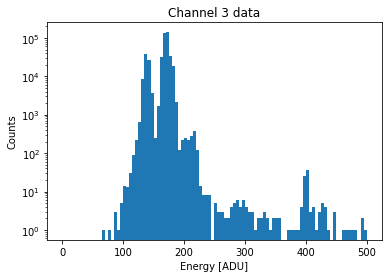

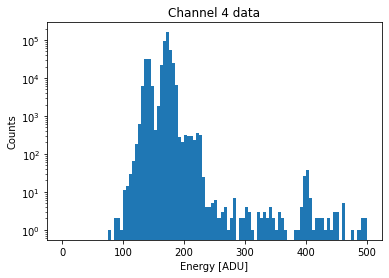

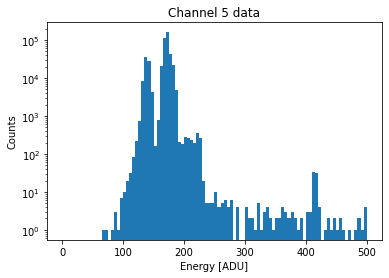

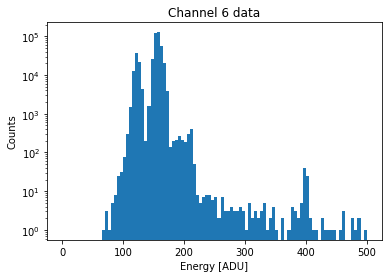

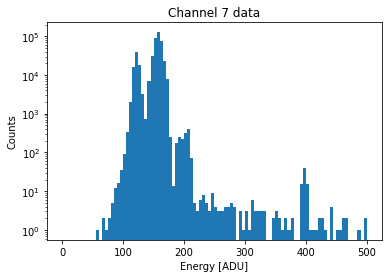

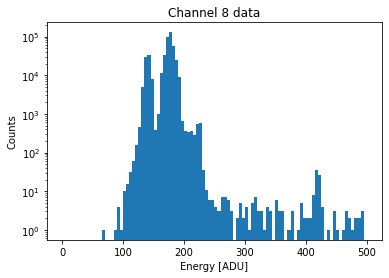

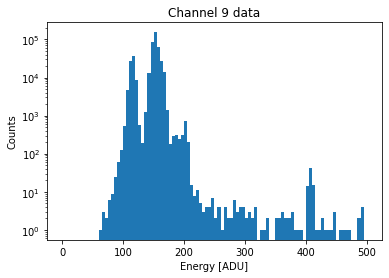

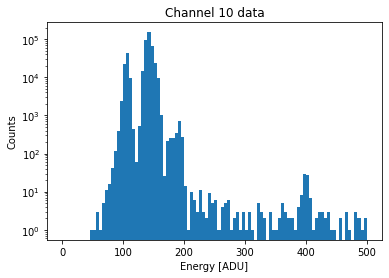

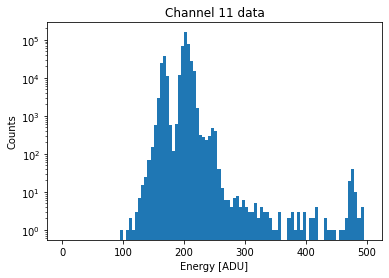

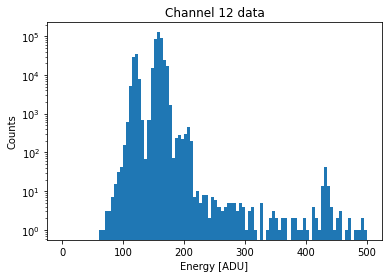

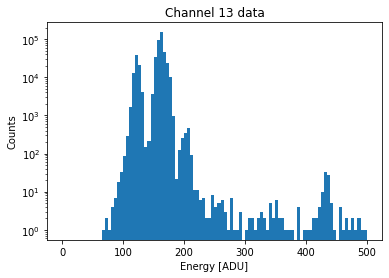

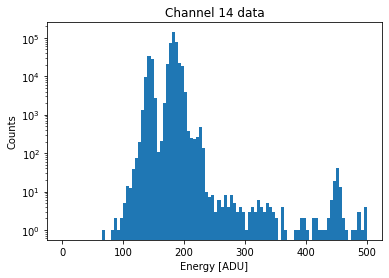

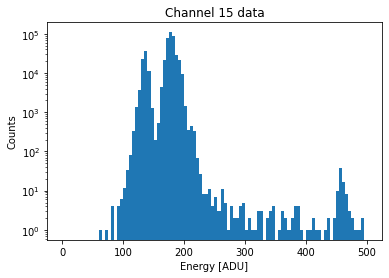

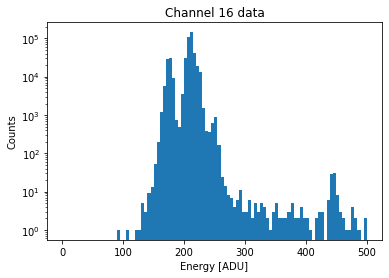

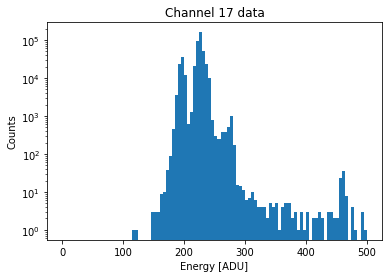

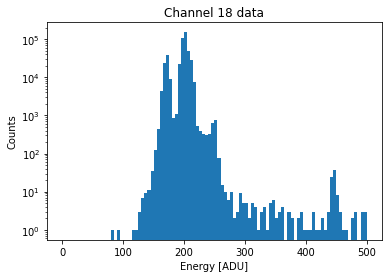

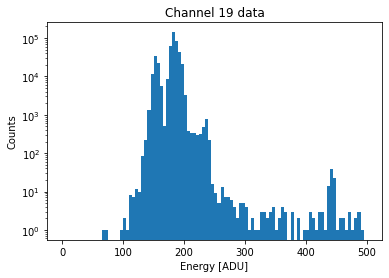

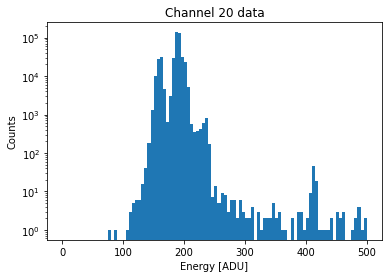

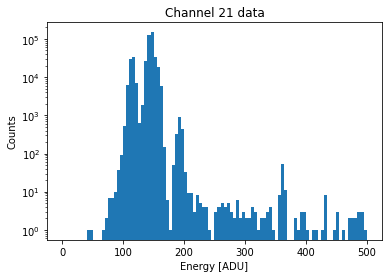

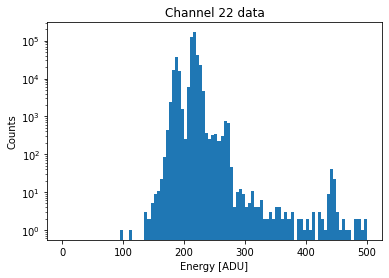

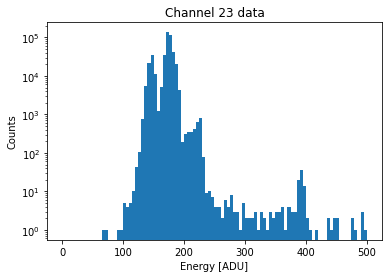

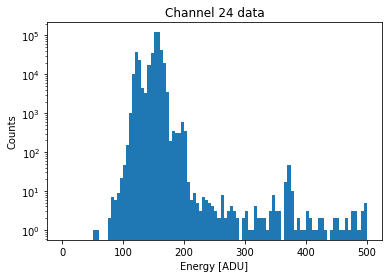

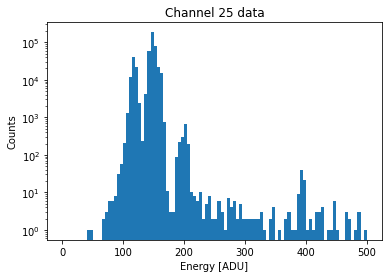

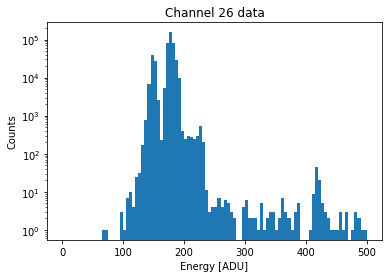

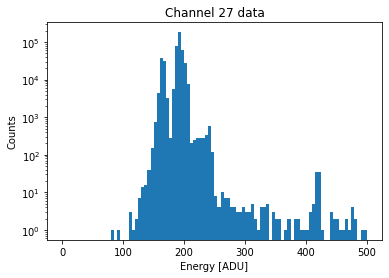

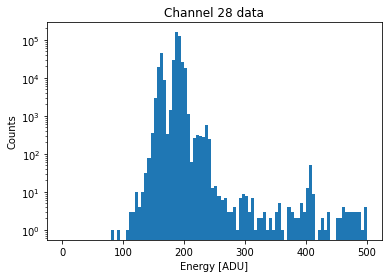

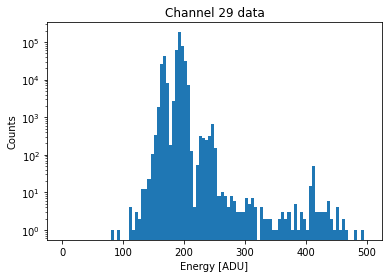

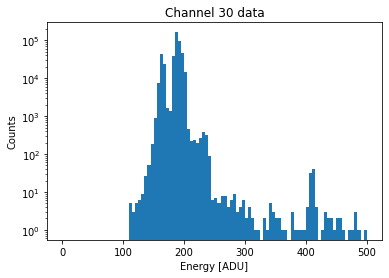

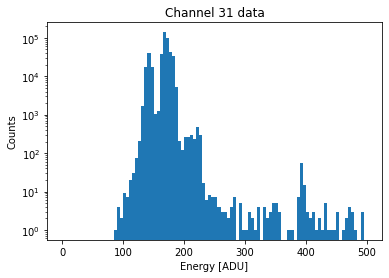

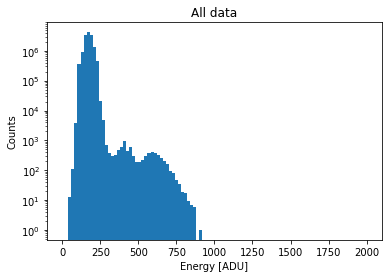

Channel averages:
 [160.36381057 148.87218633 177.31082623 164.92690841 166.35818379
 165.87151292 150.47244123 150.76479853 170.1678745  146.62744194
 136.36633245 196.90589275 151.60815272 154.69093185 176.34617323
 171.37877689 205.29210647 222.1217711  196.65276921 179.35445973
 185.34016004 140.62562058 212.16678982 170.56805121 149.47736974
 143.39165294 173.29256972 188.07255602 185.07592983 188.87001471
 185.28015692 165.92484978] 



In [11]:
# Plot raw data histograms channel by channel (also the sequential data aquisitions
# for channel 0) and all together

i = 0
plt.plot(events[:,i])
plt.title('Channel {} data'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
#plt.axis([0,200,0,200])
plt.show()
for i in range(32):
    plt.hist(events[:,i],100,(0,500))
    plt.semilogy()
    plt.title('Channel {} data'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.show()

plt.hist(events.flatten(),100,(0,2000))
plt.semilogy()
plt.title('All data'.format(i))
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
#plt.axis([0,200,0,200])
plt.show()

# Print the average values for all channels
print('Channel averages:\n', events.mean(axis=0), '\n')

In [12]:
# Determine the pedestals and print them along with their standard deviation and the
# difference between pedestals and channel mean value (this one just for sport)

#thr = [140, 140, 160, 150, 150, 140, 170, 130, 180, 150, 170, 170, 140, 200, 140, 190, 170, 150, 170, 190, 150, 150, 140, 200, 150, 150, 140, 130, 160, 130, 150, 140]
#thr = [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214]
#thr = [205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205]
thr = [206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206]
thr = [207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207]
#thr = [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130] 

peds, s = Pedestals(events, thr, 2.)
print('Pedestals:\n', peds, '\n')
print('Sigmas:\n', s, '\n')
print('Pedestals - Channel averages:\n', peds-events.mean(axis=0))

Pedestals:
 [164.17408261 152.98387327 181.54146886 169.37965121 170.91638723
 170.33583929 154.99526099 156.46653967 175.93846453 151.86711678
 141.31995828 201.6377955  156.68680533 160.10015541 181.98223367
 177.48297314 190.23964646 196.0385739  200.45173364 182.4393089
 189.46745678 144.71867401 186.92715432 174.48848026 154.95363164
 147.50239818 177.05617316 191.99407312 189.03274271 192.52721763
 188.41334288 168.42814388] 

Sigmas:
 [ 2.48373486  2.68677387  2.89609966  2.89309128  3.12066565  2.86452309
  3.12413543  3.30214366  3.5353883   3.15918062  2.95733966  2.87800784
  3.34468453  3.2758805   3.51208132  4.29738364 15.01322884  2.62550909
  2.89095947  3.35733473  2.85647581  2.88236469  3.0934499   3.4108621
  2.61410012  2.33578474  3.03462026  2.66296233  2.65259441  2.80640489
  2.88970524  2.87424094] 

Pedestals - Channel averages:
 [  3.81027204   4.11168694   4.23064262   4.4527428    4.55820343
   4.46432637   4.52281976   5.70174114   5.77059002   5.23967483

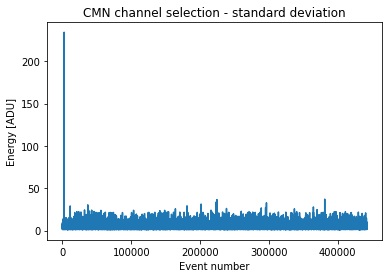

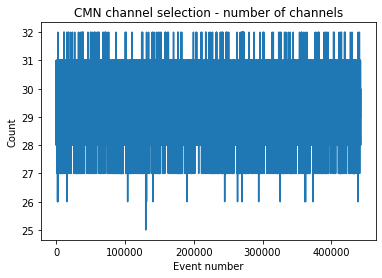

In [13]:
# Determine the common mode noise selection matrix and plot the standard deviation
# of the common mode channels and their number

ch, chn, CMNraw, std = CMNchannels(events,peds,3.)
plt.plot(std)
plt.title('CMN channel selection - standard deviation'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('CMN channel selection - number of channels'.format(i))
plt.xlabel('Event number')
plt.ylabel('Count')
plt.show()

In [14]:
## Determine the good events (common mode noise standard deviation lower than
# std_val) and print how many they are, prepare the global variables for the
# common mode gain determination step.

n = ch.shape[0]
std_val = 14.
idx = (std < std_val).nonzero()[0]
good = len(idx)
print('Number of good events (cmn std < {}): {}'.format(std_val, good))
global cmnEv
global cmnCh
cmnEv = events[idx,:]-peds
cmnEv = cmnEv[:,chMask]
cmnCh = ch[idx,:]

Number of good events (cmn std < 14.0): 441994


In [15]:
# Find the common mode noise coupling to the channels (common mode noise gain).
# p are the parameters of the minimization (the gains). This is also slow...

p = np.ones((1,len(chMask)), dtype=float)

result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})
# alternative minimization method with bounds
#bnds = np.ones((len(chMask),2), dtype=float)
#bnds[:,0] = 0.8
#bnds[:,1] = 1.2
#result = minimize(cmnGain, p, method='SLSQP', bounds=(bnds), options={'maxiter': 1e3, 'disp': True})

Optimization terminated successfully.
         Current function value: 122281595.161243
         Iterations: 18716
         Function evaluations: 22011


Common mode gains:
 [0.90263974 0.93274399 0.95016212 1.03013942 1.02653885 1.05646507
 1.10130599 1.16694963 1.17477758 1.18365774 1.18557591 1.20110302
 1.21643438 1.21751748 1.25812116 1.35844177 0.54182844 0.33164755
 1.01244056 0.94631258 1.04612651 0.94827383 1.16796348 0.91077858
 0.94917558 0.97188971 0.98344113 0.94110999 1.06932222 0.91696265
 0.91742505 0.87462955] 

Sum of gains:  32.49190127200825


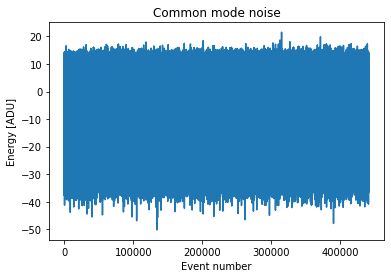

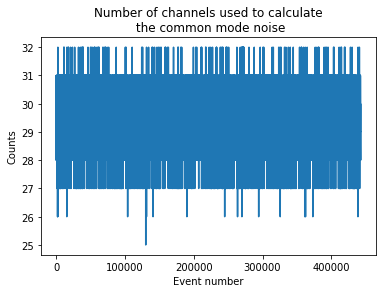

In [16]:
# remove the common mode noise (disturbances) from the event data, print the
# common mode noise gains, and plot the common mode noise along with the number
# of channels used to calculate it. The output is the variable Energy containing
# the pedestal and common mode noise subtracted event data for the good events
# (good as defined above)

g = result.x
print('Common mode gains:\n', g, '\n')
print('Sum of gains: ', g.sum())
idx = (std < std_val).nonzero()[0]
ev_good = events[idx,:]
ch_good = ch[idx,:]
energy, cmn = removeDisturbances(ev_good, peds, ch_good, g)
plt.plot(cmn)
plt.title('Common mode noise')
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('Number of channels used to calculate\n the common mode noise'.format(i))
plt.xlabel('Event number')
plt.ylabel('Counts')
plt.show()

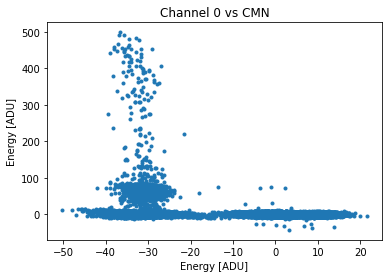

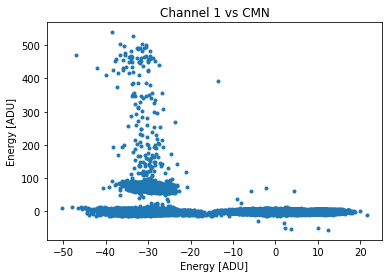

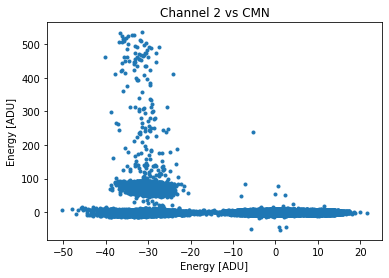

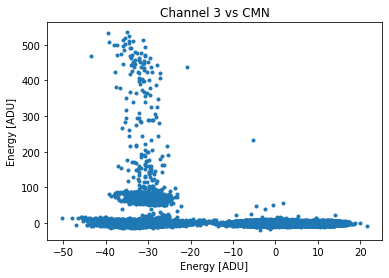

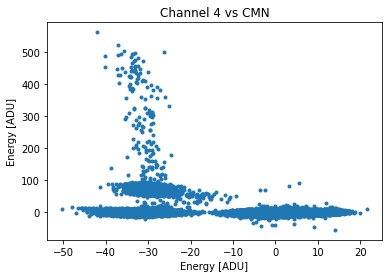

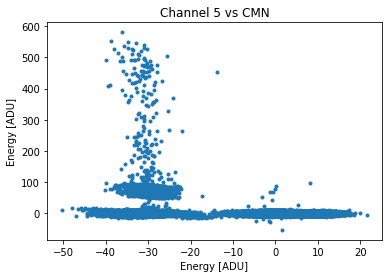

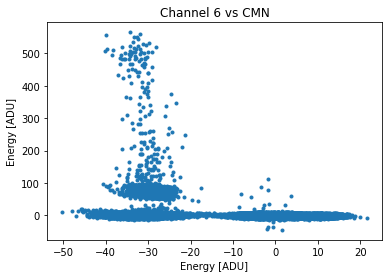

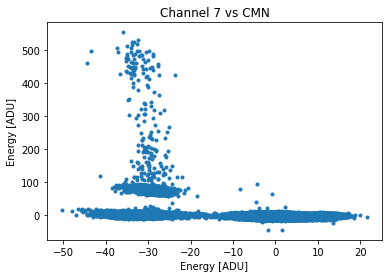

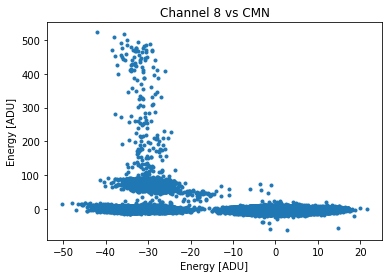

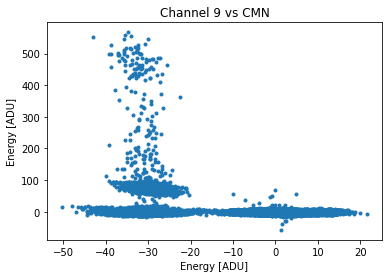

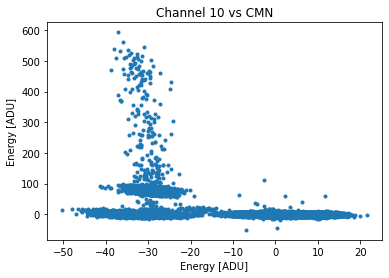

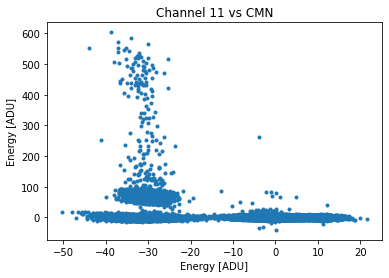

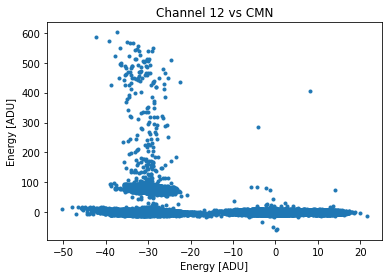

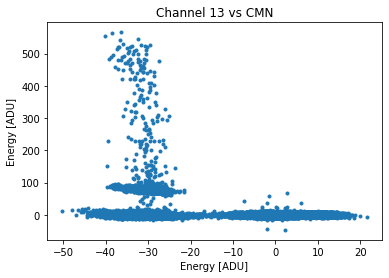

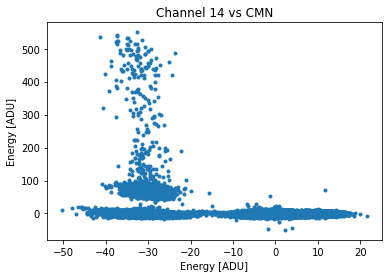

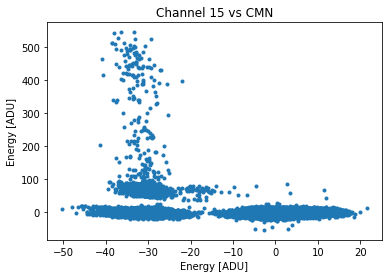

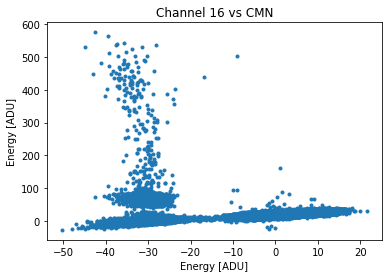

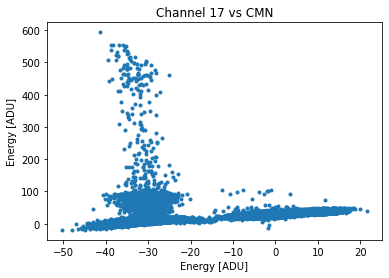

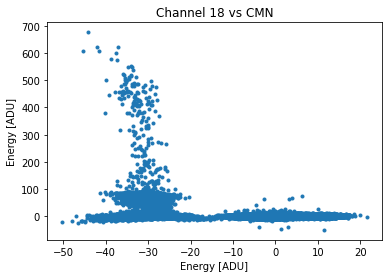

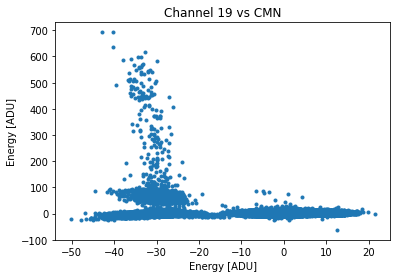

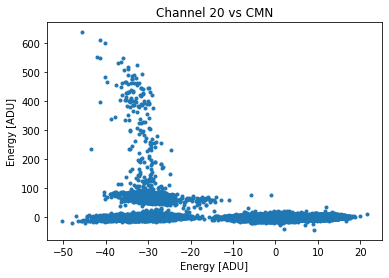

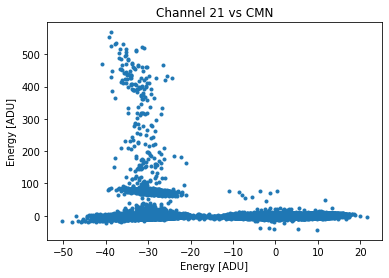

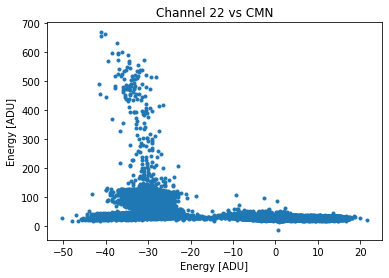

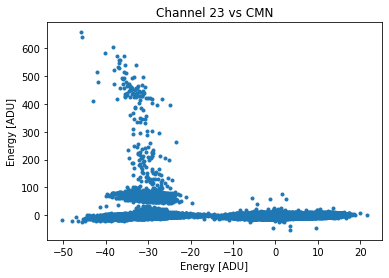

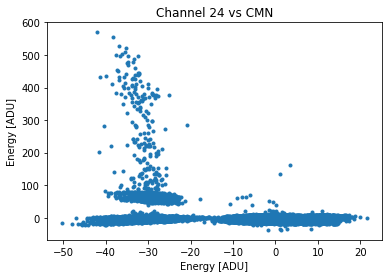

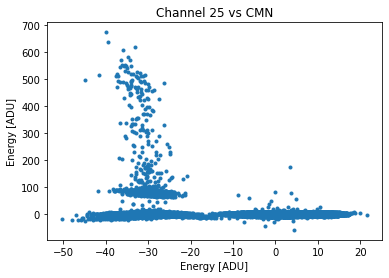

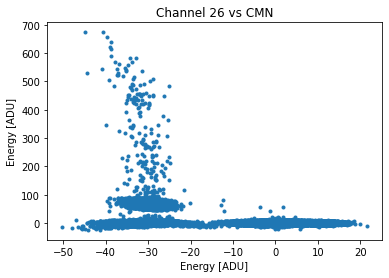

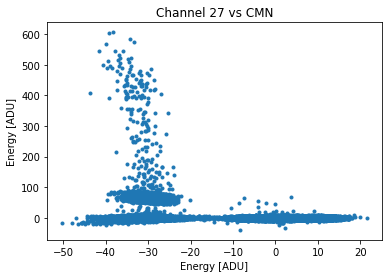

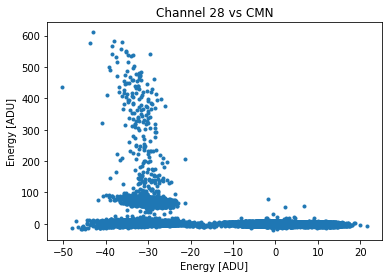

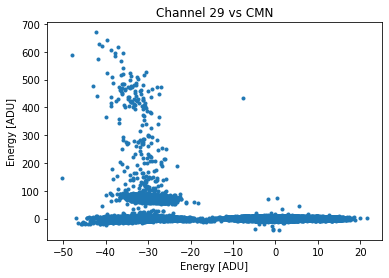

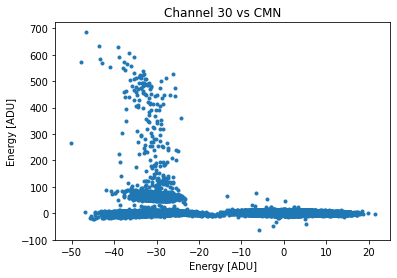

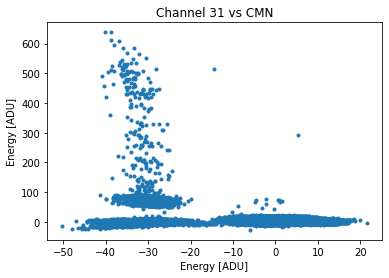

In [17]:
# Show correlation plots of the Energy data with respect to the common mode noise

for i in range(32):
    plt.plot(cmn, energy[:,i],'.')
    plt.title('Channel {} vs CMN'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Energy [ADU]')
    plt.show()

In [18]:
# Plot the Energy histogram for all channels. These histograms should have a
# pedestal peak and the MIP signal (if present)

for i in range(32):
    idx = (cmn < 10).nonzero()[0] # select the events where the signal is present
    plt.hist(energy[idx,i],220,(-100,300))
    plt.semilogy()
    plt.title('Channel {}'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.axis([-50, 300, 0.3, 30000])
    # plt.show()
    filename_pdf = str(fname) + '_ch' + str(i) + '.pdf'
    filename_png = str(fname) + '_ch' + str(i) + '.png'
    plt.savefig(path.join("IT_400_xray_207_FTh_10mins_tau5", filename_pdf))  
    plt.savefig(path.join("IT_400_xray_207_FTh_10mins_tau5", filename_png)) 
    plt.clf() 
    
import pandas as pd
my_df = pd.DataFrame(energy[idx, 4])
my_df.to_csv('ch4_americio.csv',header = False, index= False)

!zip -r xray_206_400_FTh_2mins.zip xray_206_400_FTh_2mins

from google.colab import files
files.download("IT_400_xray_207_FTh_10mins_tau5.zip")
   

updating: xray_206_400_FTh_2mins/ (stored 0%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch29.png (deflated 13%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch15.pdf (deflated 29%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch28.pdf (deflated 29%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch30.pdf (deflated 29%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch30.png (deflated 12%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch11.pdf (deflated 29%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch1.png (deflated 13%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch28.png (deflated 13%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch13.png (deflated 12%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch5.pdf (deflated 30%)
updating: xray_206_400_FTh_2mins/xray_206_400_FTh_2mins.txt_ch0.pdf (deflated 29%)
updating: xray_206_400_FTh_2mins/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [22]:
# Plot the sum histogram of the Energy of all active channels. Keep in mind that the channel
# gains are not equalized, this should be performed in a further step when every channel
# has a muon peak
energyActive = energy[idx,:]
energyActive = energyActive[:,chMask]
plt.hist((energyActive).flatten(),220,(-100,500))
plt.semilogy()
plt.title('Sum histogram')
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
plt.axis([-50, 500, 0.3, 100])
plt.show()

my_df = pd.DataFrame((energyActive[:, 6]).flatten())
my_df.to_csv('ch4_self_muons_THR130_ch6.csv',header = False, index= False)

IndexError: ignored

In [20]:
# Determine the new pedestal and electronics noise of the channels after
# pedestal and common mode noise subtraction

pedestals, noise = histParameters(energy[idx,:], 50, nsigma = 3.)
print ('Histogram pedestals:\n', pedestals, '\n')
print ('Histogram standard deviations:\n', noise)

Histogram pedestals:
 [ 1.11474078e-01 -1.27170122e-01 -2.58336740e-01 -2.48593589e-02
 -2.30799040e-01  5.00457161e-03  1.70483532e-01 -4.82761294e-01
 -7.32603349e-01 -2.72375279e-01  6.98751564e-02  3.30253461e-01
  1.03805703e-01 -1.51765118e-01 -3.03612422e-01 -2.75198188e-01
  1.65149140e+01  2.64492106e+01  1.27757897e-01  3.67666382e-01
  1.14658890e-01 -2.14527086e-01  2.98669314e+01 -3.96508443e-01
 -1.49802058e+00 -4.40929428e-02  3.10642006e-01 -3.64094967e-02
  5.82714995e-01  1.12345170e-01  7.22838023e-01 -1.18635763e-01] 

Histogram standard deviations:
 [2.06587546 2.26602236 2.4051308  2.36728835 2.6535032  2.37204306
 2.52478004 3.33252444 3.36779656 2.60333926 2.35812005 2.41063387
 2.57877686 2.58538243 2.68633996 3.36182897 8.08277534 8.57288061
 2.60215119 3.55869184 2.50253972 2.43722379 3.41614609 3.06987578
 3.7391156  2.33360836 2.57330591 2.21232317 2.72291982 2.35678985
 3.22962496 2.72045806]


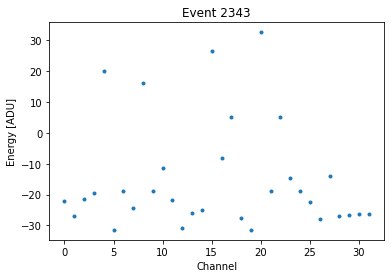

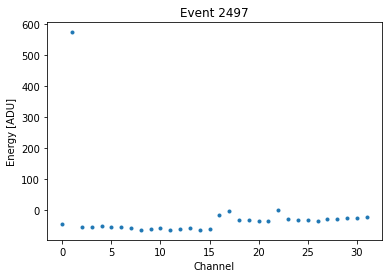

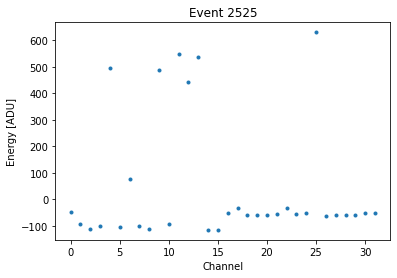

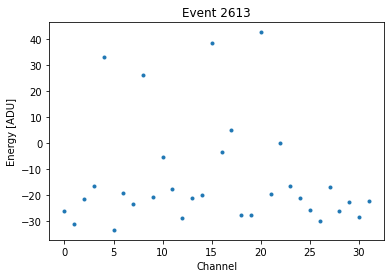

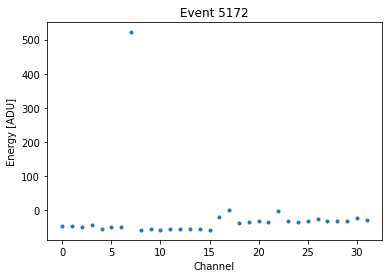

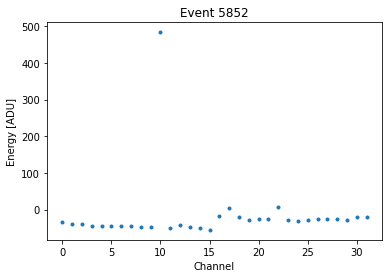

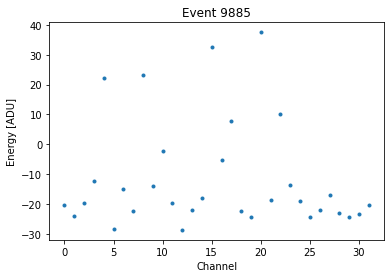

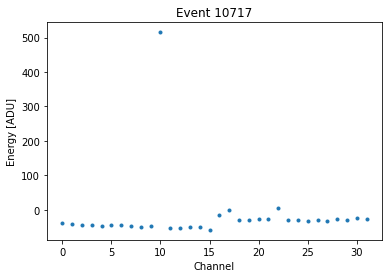

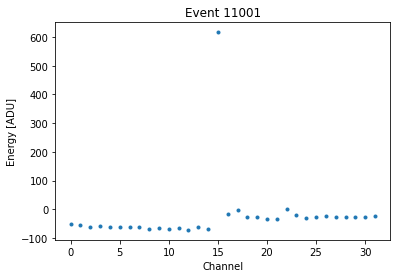

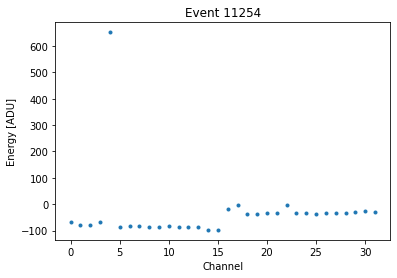

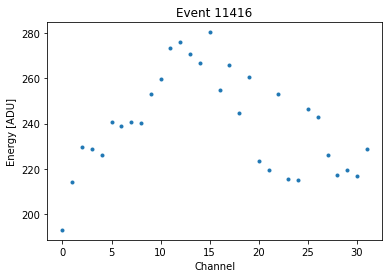

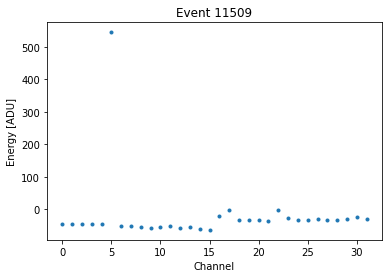

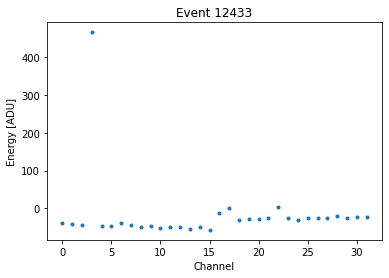

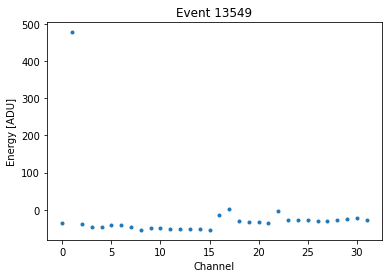

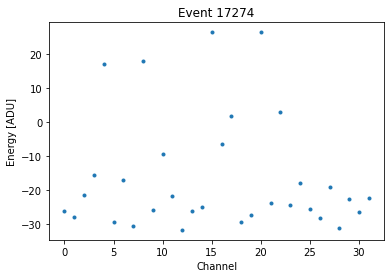

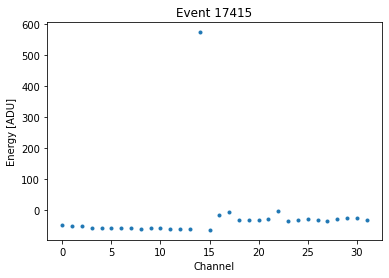

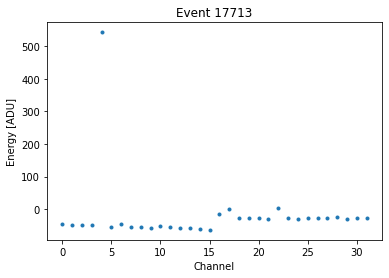

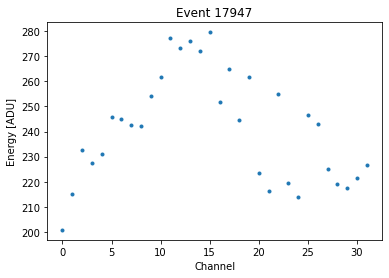

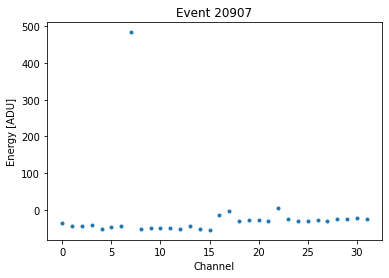

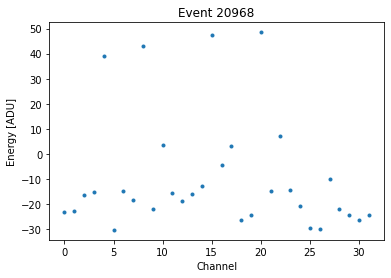

In [21]:
# Plot the first 20 bad events (pedestal subtracted data) to have a look at them

idx = (std >= std_val).nonzero()[0]
ev_bad = events[idx,:]-peds
for i in range(min(20, len(idx))):
    plt.plot(ev_bad[i,:],'.')
    plt.title('Event {}'.format(idx[i]))
    plt.xlabel('Channel')
    plt.ylabel('Energy [ADU]')
    plt.show()